In [11]:
import pandas as pd 
import numpy as np 
import jieba
from jieba import posseg
from hanziconv import HanziConv
from functools import reduce
from os import path
from ast import literal_eval
import json
from collections import Counter
from itertools import chain
from wordcloud import WordCloud 

import matplotlib.pyplot as plt 
%matplotlib inline
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']


In [2]:
data_path = '../data/'
train_path = data_path + 'raw/AutoMaster_TrainSet.csv'
test_path = data_path +'raw/AutoMaster_TestSet.csv'
stop_words_path = data_path + 'raw/stop_words.txt'
train_cut_path = data_path + 'interim/train_cut.pkl'
test_cut_path = data_path + 'interim/test_cut.pkl'
train_cut_clear_path = data_path + 'processed/train_cut_clear.pkl'
test_cut_clear_path = data_path + 'processed/test_cut_clear.pkl'
cloud_back_fig_path = '../notebooks/car.jpg'

In [3]:
def get_all_words(train_pkl_path, test_pkl_path):
    # load data
    train = pd.read_pickle(train_pkl_path)
    test = pd.read_pickle(test_pkl_path)
    # if save in pickle type file, no need this convertion
    # train[train.columns[-2:]] = train[train.columns[-2:]].applymap(literal_eval)
    # test[test.columns[-1]] = test[test.columns[-1]].apply(literal_eval)

    # get all words 
    train['words'] = train[train.columns[-2]] + train[train.columns[-1]]
    test['words'] = test[test.columns[-1]]
    ws1 = train['words'].tolist()
    ws2 = test['words'].tolist()
    words = list(chain.from_iterable(ws1)) + list(chain.from_iterable(ws2))
    
    return words

In [71]:
words = get_all_words(train_cut_clear_path, test_cut_clear_path)

In [49]:
counter = Counter(words)

In [57]:
words_cnt = counter.most_common()
w, cnt = zip(*words_cnt)
percent = cnt / np.sum(cnt) *100
top = 50

<BarContainer object of 50 artists>

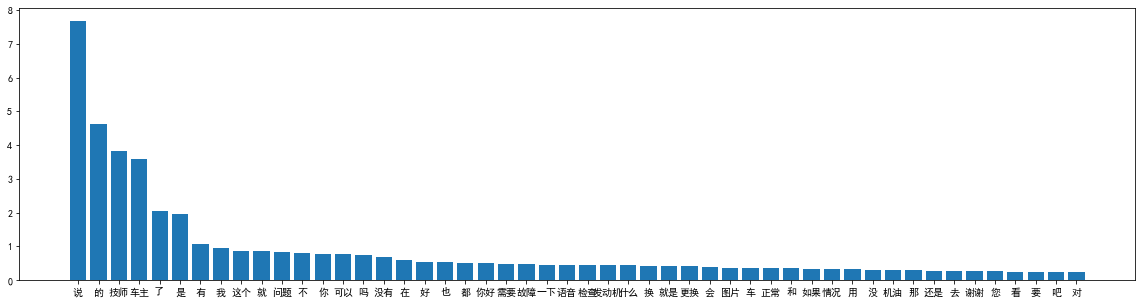

In [59]:

plt.figure(figsize=(20, 5))
#plt.bar(w[:top], cnt[:top])
plt.bar(w[:top], percent[:top])

In [75]:
join_words = ' '.join(words)

In [80]:
wc = WordCloud(collocations=False, font_path='C:/Windows/Fonts/SimHei.ttf', mask=plt.imread(cloud_back_fig_path))
img = wc.generate(join_words)

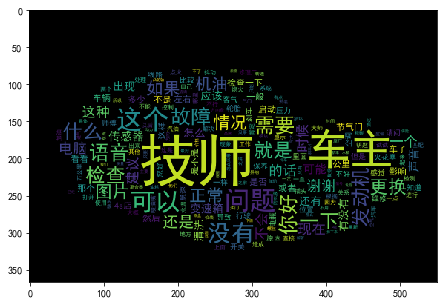

In [88]:
plt.figure(figsize=(20, 5))
plt.imshow(img)

In [4]:
def peek_lines(file_path, n):
    lines = []
    with open(file_path, encoding='utf-8') as f:
        for _ in range(n):
            lines.append(f.readline().strip('\n'))
        return lines


def read_vocab(vocab_path):
    vocab = {}
    with open(vocab_path, encoding='utf-8') as f:
        for line in f:
            item = line.strip('\n').split()
            try:
                vocab[item[0]] = int(item[1])
            except:
                print(line)
                continue
    return vocab
    

def read_stop_words(stop_words_path):
    words = set()
    with open(stop_words_path, encoding='utf-8') as f:
        for line in f:
            # words.add(line.strip('\n')) dosen't work, it will remove ' ' this speical stop word
            words.add(line.strip('\n'))
    return words

In [5]:
import sys
from pathlib import Path
config_path = str(Path.cwd().parent) 
print(config_path)
if config_path not in sys.path:
    sys.path.append(config_path)
from config.readconfig import ReadConfig

c:\Users\7153678\Desktop\AI\src\nlp2\projects\P01_QA_summarization_inference


In [6]:
import pandas as pd 
from os import path
from gensim.models.word2vec import LineSentence
from gensim.models import Word2Vec
from gensim.models.fasttext import FastText
from ast import literal_eval
from itertools import chain
from collections import Counter
import numpy as np 
import sys
from pathlib import Path
from tqdm import tqdm
import re
import pickle

In [7]:
loc_path = ReadConfig()
w2v_model_path = loc_path.get_path('w2v_model')
ft_model_path = loc_path.get_path('ft_model')
vocab_path = loc_path.get_path('vocab')
stop_words_path = loc_path.get_path('stop_words')
loc_path = ReadConfig()
train_path = loc_path.get_path('train')
test_path = loc_path.get_path('test')
sentences_path = loc_path.get_path('w2v_sentences')
w2v_model_path = loc_path.get_path('w2v_model')
ft_model_path = loc_path.get_path('ft_model')
tencent_model_path = loc_path.get_path('tencent_model')
vocab_path = loc_path.get_path('vocab')
w2v_embedding_path = loc_path.get_path('w2v_embedding')
ft_embedding_path = loc_path.get_path('ft_embedding')
tencent_embedding_path = loc_path.get_path('tencent_embedding')
train_set_x_path = loc_path.get_path('train_set_x')
train_set_y_path = loc_path.get_path('train_set_y')
test_set_x_path = loc_path.get_path('test_set_x')

In [8]:
w2v_model = Word2Vec.load(w2v_model_path)
print(w2v_model)
ft_model = FastText.load(ft_model_path)
print(ft_model)

Word2Vec(vocab=32427, size=256, alpha=0.025)
FastText(vocab=32427, size=256, alpha=0.025)


In [10]:
def read_vocab(vocab_path):
    w2i = {}
    i2w = {}
    with open(vocab_path, encoding='utf-8') as f:
        for line in f:
            item = line.strip().split()
            try:
                w2i[item[0]] = int(item[1])
                i2w[int(item[1])] = item[0]
            except:
                print(line)
                continue
    return w2i, i2w


def build_embedding(vocab_path, model_path, model_type='Word2Vector'):
    # load model
    model = None
    if model_type == 'Word2Vector':
        model = Word2Vec.load(model_path)
    elif model_type == 'FastText':
        model = FastText.load(model_path)

    # generate dict: index to vector; index is based on vocabulary
    w2i, _ = read_vocab(vocab_path)
    vocab_size = len(w2i)  
    vector_size = model.vector_size
    embedding = {}
    count = 0
    for v in w2i.keys():
        try:
            embedding[v] = model[v]
            count = count + 1
        except:
            embedding[v] = np.random.uniform(-0.25, 0.25, vector_size).astype(np.float32)

    print(f"Found {count}/{vocab_size} words in: {Path(model_path).name}")
    return embedding


def load_tencent_embedding(vocab_path, model_path):
    w2i, _ = read_vocab(vocab_path)
    vocab_size = len(w2i)
    count = 0
    with open(model_path, encoding='utf-8') as f:
        header = f.readline()
        model_vocab_size, model_vector_size = map(int, header.strip().split())
        embedding = {w: np.random.uniform(-0.25, 0.25, model_vector_size) for w in w2i.keys()}

        for _ in tqdm(range(model_vocab_size)):
            line = f.readline()
            wv = line.split(' ')
            word = wv[0]
            if word in w2i:
                try:
                    embedding[word] = np.asarray(wv[1:], dtype=np.float32)
                    count = count + 1
                except:
                    print(line)
                    continue
            if count == vocab_size:
                break
        print(f"Found {count}/{vocab_size} words in: {Path(model_path).name}")
    return embedding


def save_embedding(embedding, embedding_path):
    dump_pkl(embedding, embedding_path, over_write=True)


def dump_pkl(data, pkl_path, over_write=True):
    if os.path.exists(pkl_path) and not over_write:
        return

    with open(pkl_path, 'wb') as f:
        pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)

    print(f'save {pkl_path} ok.')

def load_pkl(pkl_path):
    with open(pkl_path, 'rb') as f:
        res = pickle.load(f)
    return res

In [29]:
tencent_embedding = load_tencent_embedding(vocab_path, tencent_model_path)

100%|██████████| 8824330/8824330 [04:26<00:00, 33092.37it/s]Found 85993/120320 words in: Tencent_AILab_ChineseEmbedding.txt



In [23]:
w2v_embedding = build_embedding(vocab_path, w2v_model_path)
ft_embedding = build_embedding(vocab_path, ft_model_path, 'FastText')

Found 32427/120320 words in: word2vector.model
Found 120320/120320 words in: fasttest.model


In [8]:
w2v_embedding = build_embedding(vocab_path, w2v_model_path)

Found 32427/120320 words in: word2vector.model


In [12]:
ft_embedding = build_embedding(vocab_path, ft_model_path, 'FastText')

Found 120320/120320 words in: fasttest.model


In [19]:
save_embedding(w2v_embedding, w2v_embedding_path)
save_embedding(ft_embedding, ft_embedding_path)

save C:/Users/7153678/Desktop/AI/src/nlp2/projects/P01_QA_summarization_inference/data/processed/w2v_embedding.pkl ok.
save C:/Users/7153678/Desktop/AI/src/nlp2/projects/P01_QA_summarization_inference/data/processed/ft_embedding.pkl ok.


In [29]:
tencent_embedding = load_tencent_embedding(vocab_path, tencent_model_path)
save_embedding(tencent_embedding, tencent_embedding_path)

100%|██████████| 8824330/8824330 [05:49<00:00, 25266.82it/s]
Found 85993/120320 words in: Tencent_AILab_ChineseEmbedding.txt
save C:/Users/7153678/Desktop/AI/src/nlp2/projects/P01_QA_summarization_inference/data/processed/tencent_embedding.pkl ok.


In [65]:
def save_data_set(train_path, test_path, train_set_x_path, train_set_y_path, test_set_x_path):
    train = pd.read_pickle(train_path)
    test = pd.read_pickle(test_path)

    train_x = train.iloc[:, -1].tolist()
    train_y = train.iloc[:, -2].tolist()
    test_x = test.iloc[:, -1].tolist()

    train_size = len(train_x)
    test_size = len(test_x)

    with open(train_set_x_path, 'w', encoding='utf-8') as fx, \
            open(train_set_y_path, 'w', encoding='utf-8') as fy, \
            open(test_set_x_path, 'w', encoding='utf-8') as f:
        for i in range(train_size):
            line_x = ' '.join(train_x[i]) + '\n'
            line_y = ' '.join(train_y[i]) + '\n'
            fx.write(line_x)
            fy.write(line_y)
            if i < test_size:
                line = ' '.join(test_x[i]) + '\n'
                f.write(line)

    print(f'Save {train_size} train data and {test_size} test data')

In [66]:
save_data_set(train_path, test_path, train_set_x_path, train_set_y_path, test_set_x_path)

Save 82867 train data and 20000 test data


In [63]:
train = pd.read_pickle(train_path)
train.columns

Index(['QID', 'Brand', 'Model', 'Question', 'Dialogue', 'Report',
       'Question_cut', 'Dialogue_cut', 'Report_cut', 'QA_cut'],
      dtype='object')

In [64]:
test = pd.read_pickle(test_path)
test.columns

Index(['QID', 'Brand', 'Model', 'Question', 'Dialogue', 'Question_cut',
       'Dialogue_cut', 'QA_cut'],
      dtype='object')

In [20]:
import tensorflow as tf
dataset_train_x = tf.data.TextLineDataset(train_set_x_path, )

In [27]:
tf.split(tf.zeros((16, 128*2)), num_or_size_splits=2, axis=1)

[<tf.Tensor: id=32, shape=(16, 128), dtype=float32, numpy=
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>,
 <tf.Tensor: id=33, shape=(16, 128), dtype=float32, numpy=
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>]